In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import pandas as pd
from io import BytesIO
from torch.utils.data import DataLoader
from tqdm import tqdm
from utils import Dataset, test_transform

c:\Users\yrasi\OneDrive\Документы\mlSandbox\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torch.load('current-EfficientNetV2-S.pth').eval().to(device)
df = pd.read_parquet('train.pqt')
dataset = Dataset(df, transforms=test_transform)
dataloader = DataLoader(dataset, batch_size=8, shuffle=False)

In [5]:
diffs = np.array([], dtype=np.float32)
with torch.no_grad():
    for x, y, _ in tqdm(dataloader):
        x = x.to(device)
        y = y.to(device)

        result = model(x)
        diffs = np.concatenate([diffs, (y - result).flatten().cpu().numpy()])

100%|██████████| 568/568 [01:03<00:00,  8.88it/s]


In [22]:
df['diff'] = diffs
df['l1_loss'] = df['diff'].abs()
df['predict'] = diffs + df['rate'].to_numpy()
df['range'] = pd.cut(df['rate'], bins=np.arange(0.0, 1.001, 0.01)).apply(lambda x: x.right)
df = df.sort_values('l1_loss').reset_index(drop=True)

0.021166682 0.5309134340720472


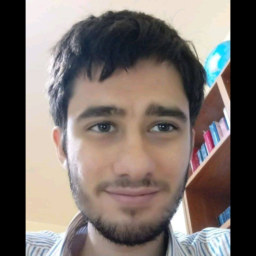

In [26]:
i = -3000
diff = df['diff'].iloc[i]
rate = df['rate'].iloc[i]
img = Image.open(BytesIO(df['img'].iloc[i]))
print(diff, rate)
img

array([[<Axes: title={'center': 'predict'}>]], dtype=object)

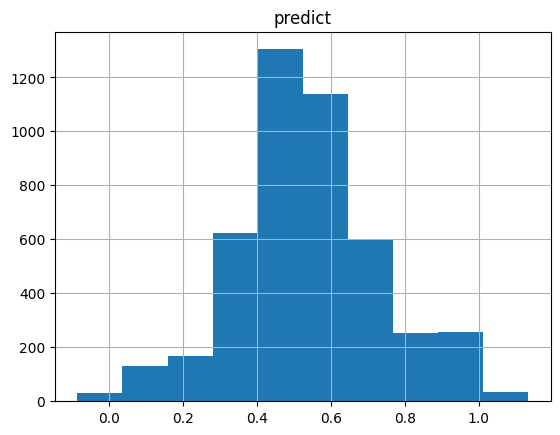

In [25]:
df.hist('predict')

<Axes: xlabel='rate'>

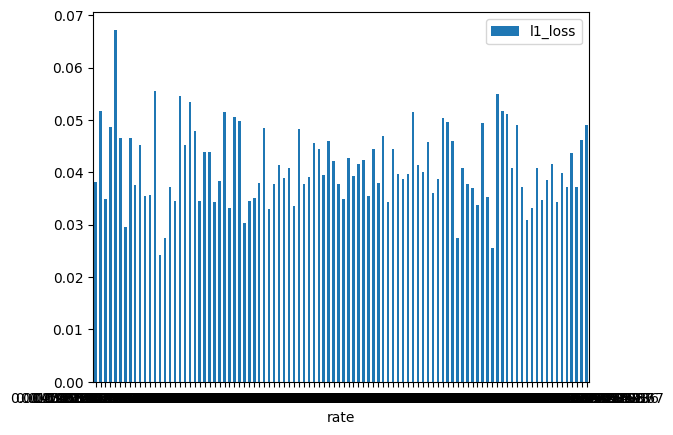

In [29]:
df[['rate', 'l1_loss', 'range']].groupby('range', as_index=False).mean().plot.bar(x='rate', y='l1_loss', rot=0)

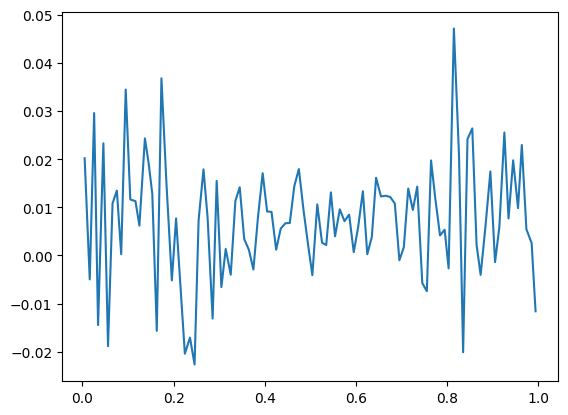

In [30]:
ranges = df[['rate', 'diff', 'range']].groupby('range', as_index=False).mean().sort_values('rate').reset_index(drop=True)
plt.plot(ranges['rate'], ranges['diff'])